In [ ]:
# 현재 작업공간의 폴더 모두 제거
!rm -rf *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 라이브러리 가져오기
import numpy as np
import os
import cv2
import random
import tensorflow as tf

In [ ]:
!unzip -u "./drive/MyDrive/U-NET data/input256npy.zip" -d "/content"
!unzip -u "./drive/MyDrive/U-NET data/label256npy.zip" -d "/content"
!unzip -u "./drive/MyDrive/U-NET data/test256npy.zip" -d "/content"

Archive:  ./drive/MyDrive/U-NET data/input256npy.zip
Archive:  ./drive/MyDrive/U-NET data/label256npy.zip
Archive:  ./drive/MyDrive/U-NET data/test256npy.zip


### 학습 데이터셋 준비

In [ ]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

data_path1 = "./input256npy"
data_path2 = "./label256npy"
data_path3 = "./test256npy"

X_train = np.zeros((len(os.listdir(data_path1)), IMG_HEIGHT, IMG_WIDTH, 1))
y_train = np.zeros((len(os.listdir(data_path2)), IMG_HEIGHT, IMG_WIDTH, 1))
X_test = np.zeros((len(os.listdir(data_path3)), IMG_HEIGHT, IMG_WIDTH, 1))
print(X_train.shape)

count = 0
for fh in sorted(os.listdir(data_path1), key=lambda x:int(x[5:-4])):
    f = os.path.join(data_path1, fh)
    
    img = np.load(f)

    X_train[count] = img
    count += 1
count=0
for fh in sorted(os.listdir(data_path2), key=lambda x:int(x[:-4])):
    l = os.path.join(data_path2, fh)
    
    img = np.load(l)

    y_train[count] = img
    count += 1
    
count=0
for fh in sorted(os.listdir(data_path3), key=lambda x:int(x[:-4])):
    t = os.path.join(data_path3, fh)
    
    img = np.load(t)

    X_test[count] = img
    count += 1

(271, 256, 256, 1)


In [ ]:
# 0~ 1사이의 값으로 정규화
maxd = 240
mind = -160
X_train = np.where(X_train>maxd, maxd, X_train)
X_train = np.where(X_train<mind, mind, X_train)
X_train += 160
X_train = X_train / 400.
print(X_train.max(), X_train.min())

1.0 0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=1)
X_valid, X_eval, y_valid, y_eval = train_test_split(X_valid, y_valid, test_size=0.4, random_state=1)
X_train.shape, X_valid.shape, X_eval.shape

((189, 256, 256, 1), (49, 256, 256, 1), (33, 256, 256, 1))

In [ ]:
maxd = 240
mind = -160
X_test = np.where(X_test>maxd, maxd, X_test)
X_test = np.where(X_test<mind, mind, X_test)
X_test += 160
X_test = X_test / 400.
print(X_test.max(), X_test.min())

1.0 0.0


In [ ]:
def aug(X_train):
  b=[]
  a=np.zeros((X_train.shape[0],256,256,1))
  for i in range(X_train.shape[0]):
    a[i,:,:,0]=cv2.flip(X_train[i,:,:,0],1)
  b.append(a)

  a=np.zeros((X_train.shape[0],256,256,1))
  for i in range(X_train.shape[0]):
    a[i,:,:,0]=cv2.flip(X_train[i,:,:,0],0)
  b.append(a)

  for j in range(1,12):
    a=np.zeros((X_train.shape[0],256,256,1))
    for i in range(X_train.shape[0]):
      a[i,:,:,0]=cv2.warpAffine(X_train[i,:,:,0], cv2.getRotationMatrix2D((128,128), j*30, 1), (256, 256))
    b.append(a)

  for j in [-4,-3,-2,-1,1,2,3,4]:
    a=np.zeros((X_train.shape[0],256,256,1))
    for i in range(X_train.shape[0]):
      a[i,:,:,0]=cv2.warpAffine(X_train[i,:,:,0], np.float32([[1,0,j*20],[0,1,0]]), (256, 256))
    b.append(a)
    
  for i in b:
    X_train=np.concatenate((X_train,i),axis=0)
  
  return X_train

In [ ]:
X_train = aug(X_train)
y_train = aug(y_train)
X_train.shape, y_train.shape, y_train.min()

((4158, 256, 256, 1), (4158, 256, 256, 1), 0.0)

In [ ]:
idx = np.arange(X_train.shape[0])
np.random.shuffle(idx)
X_train = X_train[idx]
y_train = y_train[idx]

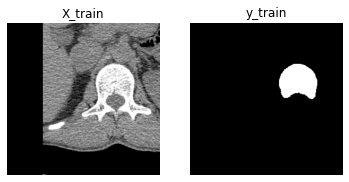

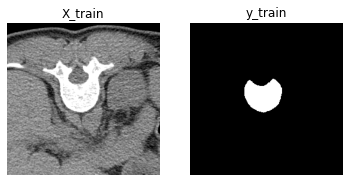

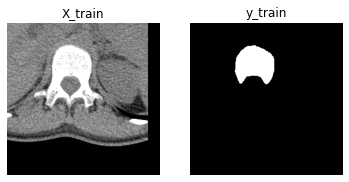

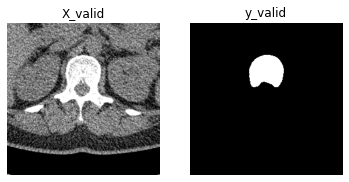

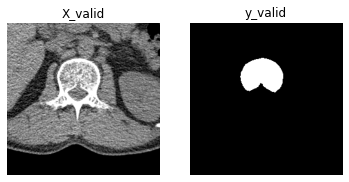

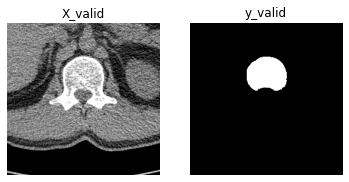

In [ ]:
# 이미지 확인
import matplotlib.pyplot as plt

def plotTrainData(a,b,c):
    for i in range(3):
        ix = np.random.randint(0, len(a))        
        plt.subplot(1,2,1)
        plt.title("X_" + c)
        plt.imshow(np.squeeze(a[ix]), 'gray')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("y_" + c)
        plt.imshow(np.squeeze(b[ix]), 'gray')
        plt.axis('off')
        plt.show()
        
plotTrainData(X_train,y_train, 'train')
plotTrainData(X_valid,y_valid, 'valid')

### 모델 생성

![대체 텍스트](https://drive.google.com/uc?export=view&id=1vSx_i5kIBjaHTk5pvaa-yOXTX_69UzZh)

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### loss function 정의

* dice coefficient

![이미지](https://i.stack.imgur.com/OsH4y.png)

In [ ]:
# loss function 정의
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f) + K.sum(y_pred_f) + np.spacing(1))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [ ]:
# build the model
mcp = ModelCheckpoint('unet.h5',monitor='val_loss', save_best_only=True, mode='min')
model = unet()
sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])

### 학습

In [ ]:
from google.colab import files
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=20, batch_size=16, callbacks=mcp)
files.download('unet.h5')

Epoch 1/20
260/260 [==============================] - 191s 657ms/step - loss: 0.0509 - accuracy: 0.9465 - val_loss: 0.0424 - val_accuracy: 0.9572
Epoch 2/20
260/260 [==============================] - 161s 619ms/step - loss: 0.0112 - accuracy: 0.9874 - val_loss: 0.0275 - val_accuracy: 0.9716
Epoch 3/20
260/260 [==============================] - 161s 620ms/step - loss: 0.0045 - accuracy: 0.9941 - val_loss: 0.0033 - val_accuracy: 0.9965
Epoch 4/20
260/260 [==============================] - 161s 620ms/step - loss: 0.0034 - accuracy: 0.9950 - val_loss: 0.0060 - val_accuracy: 0.9933
Epoch 5/20
260/260 [==============================] - 162s 622ms/step - loss: 0.0030 - accuracy: 0.9954 - val_loss: 0.0024 - val_accuracy: 0.9971
Epoch 6/20
260/260 [==============================] - 162s 623ms/step - loss: 0.0027 - accuracy: 0.9957 - val_loss: 0.0022 - val_accuracy: 0.9974
Epoch 7/20
260/260 [==============================] - 161s 619ms/step - loss: 0.0024 - accuracy: 0.9960 - val_loss: 0.0031 -

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

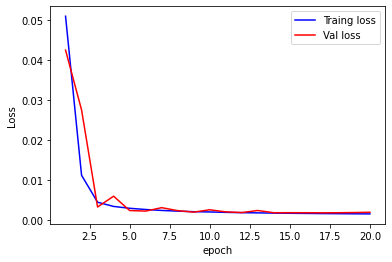

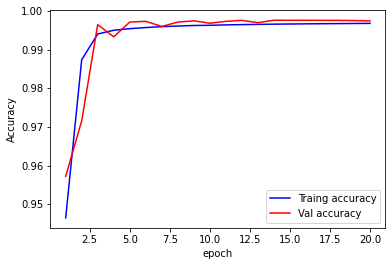

In [ ]:
# 결과확인
historyDict=hist.history

acc=hist.history['accuracy']
val_acc=hist.history['val_accuracy']
loss=hist.history['loss']
val_loss=hist.history['val_loss']

epo = range(1, len(acc)+1)
plt.plot(epo, loss, 'b', label="Traing loss")
plt.plot(epo, val_loss, 'r', label="Val loss")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('drive/MyDrive/unet_loss.png')
plt.show()


plt.plot(epo, acc, 'b', label="Traing accuracy")
plt.plot(epo, val_acc, 'r', label="Val accuracy")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('drive/MyDrive/unet_acc.png')
plt.show()


### test set 검증

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
model = tf.keras.models.load_model('drive/MyDrive/unet_mse_최종.h5')

def plotPredictions(X_train_, y_train_, X_valid_, y_valid_, X_test_, y_test_, trainModel):
    model = trainModel     

    ix = np.random.randint(0, len(X_train_))
    input_ = X_train_[ix:ix+1]
    mask_ = y_train_[ix:ix+1]
    preds_train = model.predict(input_)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    plt.imshow(np.squeeze(input_[0]), 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    plt.imshow(np.squeeze(mask_[0]), 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(np.squeeze(preds_train_t[0]), 'gray')
    plt.savefig('drive/MyDrive/1.png')
    plt.show()
    
    ix = np.random.randint(0, len(X_valid_))
    input_ = X_valid_[ix:ix+1]
    mask_ = y_valid_[ix:ix+1]
    preds_valid = model.predict(input_)
    preds_valid_t = (preds_valid > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_valid")
    plt.axis('off')
    plt.imshow(np.squeeze(input_[0]), 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_valid")
    plt.axis('off')
    plt.imshow(np.squeeze(mask_[0]), 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(np.squeeze(preds_valid_t[0]), 'gray')
    plt.savefig('drive/MyDrive/2.png')
    plt.show()
    
    ix = np.random.randint(0, len(X_test_))
    input_ = X_test_[ix:ix+1]
    mask_ = y_test_[ix:ix+1]
    preds_test = model.predict(input_)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    plt.figure(figsize=(10,10))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    plt.imshow(np.squeeze(input_[0]), 'gray')
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    plt.imshow(np.squeeze(mask_[0]), 'gray')
    plt.subplot(1,3,3)
    ret = model.evaluate(input_, mask_)
    plt.title("Prediction: %.4f" % (ret[1]))
    plt.axis('off')
    plt.imshow(np.squeeze(preds_test_t[0]), 'gray')
    plt.savefig('drive/MyDrive/3.png')
    plt.show()

In [ ]:
preds_test = model.predict(X_eval)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
ret = model.evaluate(X_eval, y_eval)
print(f'\n\n테스트 데이터셋에 대한 결과\nloss : {ret[0]:.6f} \taccuracy : {ret[1]:.6f}')

2/2 [==============================] - 1s 42ms/step - loss: 0.0022 - accuracy: 0.9972


테스트 데이터셋에 대한 결과
loss : 0.002158 	accuracy : 0.997156


1/1 [==============================] - 0s 63ms/step - loss: 0.0012 - accuracy: 0.9951


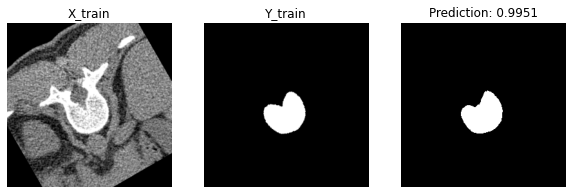

1/1 [==============================] - 0s 70ms/step - loss: 0.0017 - accuracy: 0.9977


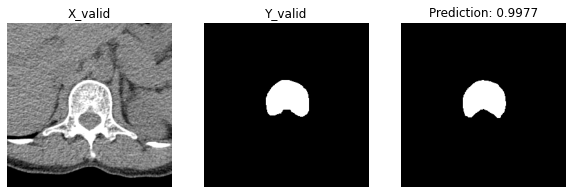

1/1 [==============================] - 0s 62ms/step - loss: 0.0018 - accuracy: 0.9976


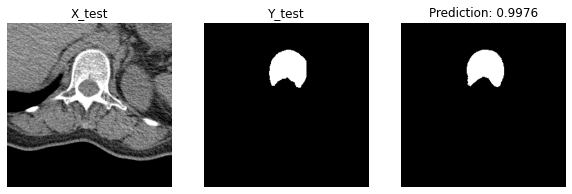

In [ ]:

plotPredictions(X_train, y_train, X_valid, y_valid, X_eval,y_eval, model)

In [ ]:

preds = np.zeros((X_test.shape[0], IMG_HEIGHT, IMG_WIDTH, 1))
for i in range(X_test.shape[0]):
  pred_test=model.predict(X_test[i:i+1])
  preds[i] = (pred_test>0.5).astype(np.uint8)

In [ ]:

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

data_path3 = "./test256npy"

X_test = np.zeros((len(os.listdir(data_path3)), IMG_HEIGHT, IMG_WIDTH, 1))
print(X_test.shape)

count = 0

for fh in sorted(os.listdir(data_path3), key=lambda x:int(x[:-4])):
    t = os.path.join(data_path3, fh)
    
    img = np.load(t)

    X_test[count] = img
    count += 1

(810, 256, 256, 1)


In [ ]:
# 0~ 1사이의 값으로 정규화

X_test += 500
X_test = X_test / 1800

np.save('drive/MyDrive/spine.npy', X_test*preds)

In [ ]:
spine = np.load('drive/MyDrive/spine.npy')
for i in range(spine.shape[0]):
  cv2.imwrite(f'drive/MyDrive/spine256npy/{i+1}.png',spine[i].reshape(256,256)*255)

# references

https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

https://deep-deep-deep.tistory.com/56

https://kjhov195.github.io/2020-01-02-optimization_2/